# ECON570 Assignment2_Qi Liu

In [39]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import graphviz as gr
import csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm

In [40]:
#set random seeds
random.seed(100)
np.random.seed(100)

 ### 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.
 ### 1.1 Simulate a DGP
 $y_i = \alpha + \tau*T_i+ \beta*X + e_i$

$e_i \sim N(0,\sigma^2)$

where 
$\alpha$ is the intercept; $\tau$ is the treatment effect; T is the treatment;  $\beta$ is the coefficients on covariate; X is the covariate; e is the disturbance

In [41]:
alpha=2
tau = 3
beta=2
n=100
corr = .5
conf = False
T= np.random.normal(0,1,n)
X = np.random.uniform(0,0.5,n)
e = np.random.normal(0,10,n)
Y = 2+ 3* T + 2*X +e

In [42]:
data_1 = pd.DataFrame(dict(Y = Y,
                           Treatment = T,
                           X = X))
#output the dataset
data_1.to_csv('data_1.csv', index=False)

In [43]:
data_1

,Y,Treatment,X
0,-4.108428,-1.749765,0.201440
1,23.285076,0.342680,0.177149
2,11.189700,1.153036,0.250307
3,1.524414,-0.252436,0.222588
4,0.876232,0.981321,0.045216
...,...,...,...
95,10.782577,0.003017,0.271140
96,2.106113,-0.076023,0.041132
97,17.822871,0.003958,0.317818
98,5.937474,-0.185014,0.398203


### 1.2 Illustrate your DGP with a DAG

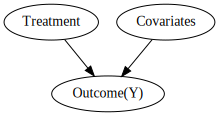

In [44]:
g_1 = gr.Digraph()
g_1.edge("Treatment", "Outcome(Y)")
g_1.edge("Covariates", "Outcome(Y)")
g_1

### 1.3 Monte Carlo experiment
#### a. not control for any covariates

$y_i = \alpha +\tau*T_i+e_i$

In [33]:
#define a function
def fn_generate_data(tau,N,p,p0,corr,conf = False,flagX = False):
    nvar = p+2
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
    
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) 
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0
    Yab = tau*T+X@beta0+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [34]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [35]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
  
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [45]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
 
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
   
    return (bias,rmse,size)

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
           
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]

            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


In [46]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,5,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.03it/s]


In [48]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.006374096336077445, RMSE=0.20457678231004428, size=0.054
N=1000: bias=0.0013170270394993935, RMSE=0.06435652455507904, size=0.045


#### b. control for all the covariates that affect the outcome

$y_i = \alpha + \tau*T_i+ \beta*X + e_i$

In [49]:
# Use same DGP as case a
tau = 2
corr = .5
conf=False
p = 100
p0 = 1
Nrange = range(100,1000,2) 

flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:02<00:00, 162.29it/s]


In [50]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,5,1,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_ahat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.22it/s]


In [52]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0011218141323538152, RMSE=0.14521905977377048, size=0.385
N=1000: bias=-0.00015183476507183525, RMSE=0.04575924224420856, size=0.009


From the output of case A and caseB, we find that controlling covariates could enhance the estimator which performs better for the bias,RMSE and size of your treatment effect estimate(both N=100 and N=10000

### 1.4 an example of a real-life situation

When we want to know the effect of temperature on precipitation, but altitude, latitude and longitude, local humidity and other variables may also affect precipitation.In this case, temperature is the independent variable, precipitation is the dependent variable, and altitude, latitude and longitude and local humidity are the covariables.

## 2. Simulate a DGP with a confounder.
### 2.1 Simulate a DGP
$y_i = \alpha +\tau*T_i+ \beta*X + 0.4* C + e_i $


where  C is the confounder,  T is the treatment;   𝜏  is the treatment effect; 𝛼  is the intercept; 𝛽  is the coefficients on covariate; X is the covariate; e is the disturbance

In [71]:
alpha=2
tau = 3
beta=2
n=100
corr = .5
conf = False
T= np.random.normal(0,1,n)
X = np.random.uniform(0,0.5,n)
C = np.random.normal(0,1,n)
e = np.random.normal(0,10,n)
Y = 2+ 3* T + 2*X + 0.6 * C+ e

In [72]:
data_2 = pd.DataFrame(dict(Y = Y,
                           Treatment = T,
                           Confounder = C,
                           X = X))
#output the dataset
data_2.to_csv('data_2.csv', index=False)

In [73]:
data_2

,Y,Treatment,Confounder,X
0,-2.408668,-0.159633,-1.388541,0.029209
1,8.813386,1.815076,1.534360,0.154235
2,16.596936,0.675753,-0.316069,0.269878
3,14.923134,2.363238,0.626968,0.273630
4,-5.932523,1.928127,-0.076412,0.310560
...,...,...,...,...
95,-2.006903,-0.347429,-1.100627,0.402572
96,15.137777,-0.699776,0.093098,0.427418
97,-10.029119,-1.901757,0.871639,0.469689
98,-5.886589,-0.308278,-0.868286,0.247962


### 2.2 Illustrate your DGP with a DAG

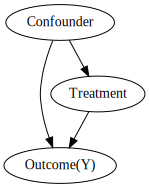

In [74]:
g_2 = gr.Digraph()

g_2.edge("Confounder", "Outcome(Y)")
g_2.edge("Confounder", "Treatment")
g_2.edge("Treatment", "Outcome(Y)")
g_2

### 2.3 Monte Carlo experiment
#### a. fail to control for the confounder

$y_i = \alpha + \tau*T_i+ \beta*X + e_i$

In [75]:
def fn_generate_data_conf(tau,N,p,p0,corr,conf = True):
   
    nvar = p+2 
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
    
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) 
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:]
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 
    Yab = tau*T+X@beta0+conf_mult*0.4*C+err
        
    return (Yab,T,X)

In [76]:
tau = 2
corr = .5
conf= False
p = 5
p0 = 1 #
Nrange = range(100,1000,2) 

flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 422.93it/s]


In [69]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data_conf(tau,N,5,1,corr,conf)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_ahat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.55it/s]


In [70]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.00409461030451784, RMSE=0.1415404219037701, size=0.369
N=1000: bias=0.0002343495287401296, RMSE=0.04561170575769043, size=0.006


#### b. control for the confounder

$y_i = \alpha +\tau*T_i+ \beta*X + 0.4* C + e_i $

In [131]:
tau = 2
corr = .5
conf= True
p = 5
p0 = 1

In [149]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data_conf(tau,N,5,1,corr,conf)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_ahat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.71it/s]


In [133]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.010895223067282987, RMSE=0.1647760682025798, size=0.435
N=1000: bias=-0.0008890105873970033, RMSE=0.04953177857308198, size=0.014


### 2.4 an example of a real-life situation

When we want to determine how long a week of physical activity affected physical fitness, we should consider the confounder. The treatment is exercise time, the outcome is physical fitness, and the confounder is Age. 

When we do not consider the confounder, we may get the conclusion that the longer you exercise, the worse your health. However, after group by age, we can get that the exercise time and physical health degree in each age group are positive.

## 3.Simulate a DGP with selection bias into the treatment
### 3.1 Simulate a DGP

$y_i = \tau*T_i+e_i$

$Z_i = \beta*T_i+e_i$ 

After considering the selection bias, the model would be:

$y_i = \tau *T_i+ \lambda*Z_i + e_i$

In [85]:
tau = 3
lambda_z = .5
beta = 2
N = 100
conts = True

T= np.random.normal(0,1,n)
Y=3*T + e
Z= 2*T +e

In [86]:
data_3 = pd.DataFrame(dict(Y = Y,
                           Treatment = T,
                           Z = Z))
#output the dataset
data_3.to_csv('data_3.csv', index=False)

In [87]:
data_3

,Y,Treatment,Z
0,-4.190132,-0.345023,-3.845108
1,4.169272,1.343400,2.825872
2,14.041235,0.607224,13.434011
3,3.945259,-0.321574,4.266832
4,-16.733366,-0.813729,-15.919636
...,...,...,...
95,0.909846,1.339744,-0.429898
96,17.560879,1.078156,16.482722
97,-11.011208,-1.074999,-9.936209
98,-7.684979,-0.249424,-7.435555


### 3.2 Illustrate your DGP with a DAG

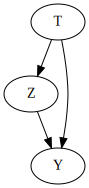

In [88]:
g_3 = gr.Digraph()
g_3.edge("T", "Z")
g_3.edge("T", "Y")
g_3.edge("Z", "Y")
g_3.node("Z", "Z")
g_3

### 3.3 Monte Carlo experiment
#### a.control for the variable in between the path from cause to effect
$y_i = \tau *T_i+ \lambda*Z_i + e_i$

In [96]:
def fn_generate_data_bias(tau,N,beta,lambda_z,conts):
 
    nvar = p+1 #1 bias
    corr = 0.5 
        
    allZ = fn_generate_multnorm(N,corr,nvar)
    W0 = allZ[:,0].reshape([N,1]) 
    C = allZ[:,1].reshape([N,1]) 
    Z = allZ[:,2:] 
    
    T = fn_randomize_treatment(N)
    err = np.random.normal(0,1,[N,1])
    
    Y = tau*T+lambda_z*Z+err
        
    return (Y,T,Z)

In [102]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data_bias(tau,N,2,0.5,conts)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.38it/s]


In [103]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.00609209378976346, RMSE=0.21663110363839333, size=0.049
N=1000: bias=0.0018189210755674581, RMSE=0.0691420841803865, size=0.046


#### b. not control for the variable in between the path from cause to effect
$y_i = \tau*T_i+e_i$

In [104]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data_bias(tau,N,0,0,conts)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.63it/s]


In [105]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.004979683674327243, RMSE=0.20144149072604386, size=0.057
N=1000: bias=-0.0021921779418158853, RMSE=0.06271405816830024, size=0.052


### 3.4 an example of a real-life situation

When we study the learning situation of college students in USA, if the sample space is only Top30 university , there will certainly be a great difference in the overall survey results, which is selection bias. In the random variable experiment, the error of the sample we choose is very large and cannot represent the whole, which leads to selection bias.